# Quantum Circuit Born Machine (QCBM)
The Quantum Circuit Born Machine learns generative models in machine learning using state vectors.  
The learning circuit consists of an arbitrary rotation one qubit gates and entanglement gates.

### Generative model

In the generative model, we learn to reduce the difference between the probability distribution of the model we want to learn and the probability distribution of the measurements of the quantum circuit.  

For example, if you want to learn a coin with a probability of $2/3$ of showing up, the probability that the quantum circuit measure "1" must be $2/3$.

In addition, if we want to learn the probability of each face appearing on an uneven tetrahedral dice, such as $0.2, 0.4, 0.1, 0.3$, we need to learn the output state of the quantum circuit to be, for example, $\lvert \psi \rangle = \sqrt{0.2}\lvert 00 \rangle + \sqrt{0.4}\lvert 01 \rangle + \sqrt{0.1}\lvert 10 \rangle + \sqrt{0.3}\lvert 11 \rangle$.

### Cost function

Such learning uses the following cost function $C(\theta)\ ( \theta$: rotation angle parameter of the quantum circuit).

$$
C(\theta) = -\frac{1}{D}\sum^D_{d=1}\ln\bigl(\max(\epsilon, P_{\theta}(x^{(d)})) \bigr)
$$

$D$: The size of dataset.  
$P_{\theta}(x)$: Probability of obtaining data $x$ by sampling from quantum circuit.

A dataset is a fixed number of outputs from the generative model you want to learn.  
For example, assuming the above tetrahedral dice with faces $\{1, 2, 3, 4\}$, the dataset consisting of 10 outputs will look like $\{2, 4, 3, 1, 2, 2, 4, 1, 2, 4\}$.  

The mechanism by which the difference between distributions can be minimized by minimizing this loss function is as follows.

The larger $P_{\theta}(x^{(d)})\ (\leq 1)$ is, the smaller $-\ln(P_{\theta}(x^{(d)}))$ will be.  

Therefore, if we make the output probability $P_{\theta}(x^{(d)})$ of the quantum circuit larger for the more frequent occurrence of $x^{(d)}$ in the original data set, we can reduce the loss function.

The loss function is minimized when the probability distribution of the quantum circuit output and the dataset are equal.

Reasons for implementing $\epsilon$:  
If some data $x$ in the dataset were not included in any of the sampling results from the quantum circuit, the negative log likelihood function would be infinite. Since the number of sampling times is finite, this can happen for data that is only slightly contained in the dataset.
To prevent this, we introduce a minute quantity $\epsilon$.

## Implementation

This time, as a simple example, we will let a quantum circuit learn a Gaussian distribution.

Install Blueqat.

In [ ]:
!pip install blueqat

### Preparing the Data Set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Create a data set by sampling 500 times from a Gaussian distribution.  
In this case, we will use the frequency distribution divided into 16 parts for training, since we are training on a four-qubit circuit.

[  4.   5.  24.  33.  72.  75. 123. 134. 141. 150.  95.  70.  34.  19.
  11.  10.]


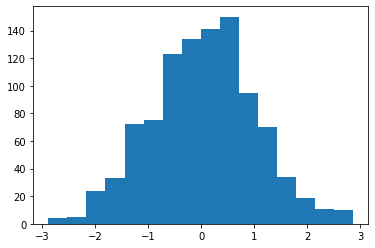

In [16]:
samples = np.random.normal(0, 1, 1000)

hist = plt.hist(samples, bins = 16)
data_prob = hist[0]
print(data_prob)

The measurement probabilities of the 16 different outputs of the quantum circuit, from $0000$ to $1111$, correspond to the above frequency distribution.  
That is, the measurement probabilities of $0111$ and $1000$ are the peaks of the probability distribution, and the measurement probabilities of $0000$ and $1111$ are the skirts of the probability distribution.

### Preparing the circuit
Let's try to build a circuit with 4 qubits, using U gates and CX gates.

```
|0> --U--*--------X--[repeat]--[m]
|0> --U--X--*-----|--[repeat]--[m]
|0> --U-----X--*--|--[repeat]--[m]
|0> --U--------X--*--[repeat]--[m]
```

The gradient descent method is used to update parameters.

3.741895368024771
3.551340645779678
3.550538803210651
3.553410688807561
3.487287043852308
3.3580671222747704
3.305433900113203
3.3228435810998014
3.2530355768381196
3.218985386953002
3.2050002893505374
3.280530716621693
3.427056567300267
3.239475405993254
3.163990780007587
3.0431840047173546
3.05070497985069
2.9745207370438607
2.9444285639105323
2.8881286965146797
2.916350620391723
2.892824823152307
2.87559155267479
2.8775749614491057
2.897228309249292
2.870765664516464
2.898529460897346
2.924744041837688
2.9306804904879162
2.8790694118430635
2.851581029953341
2.8499904151466118
2.858918335609967
2.851433106891149
2.8347690910386563
2.8541308644705485
2.867340818470598
2.8578511604608896
2.8169684334146985
2.8254749888769
2.790633444444826
2.774932469608608
2.7544420704765886
2.7510792155501016
2.724724868947823
2.751473474719897
2.7233787467155057
2.717587910013746
2.7311284164965604
2.7246538924434045
2.706287309820405
2.6974873722048214
2.6782087385936375
2.675077416270507
2.6765863

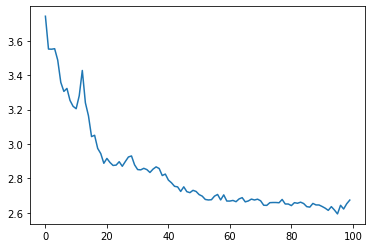

1533.2901310920715


In [32]:
from blueqat import Circuit
import time

np.random.seed(30)

#initial parameters
param_init = [np.random.rand()*np.pi*2 for i in range(36)]

#1qubit state preparation
def arbi(para):
    circ1 = Circuit()
    circ1.u(para[0],para[1],para[2])[0]
    circ1.u(para[3],para[4],para[5])[1]
    circ1.u(para[6],para[7],para[8])[2]
    circ1.u(para[9],para[10],para[11])[3]
    return circ1
    
#cx loop circuit
def loop():
    circ2 = Circuit()
    circ2.cx[0,1]
    circ2.cx[1,2]
    circ2.cx[2,3]
    circ2.cx[3,0]
    return circ2

#QCBM circuit
def qcbm(a):
    u = Circuit()
    u += arbi(a[0:12])
    u += loop()
    u += arbi(a[12:24])
    u += loop()
    u += arbi(a[24:36])
    u += loop()
    return u

def nnl_loss(data, sampled, shots):
    D = np.sum(data)
    nnl_cost = 0
    eps = (1/shots)
    for i in range(16):
        key = format(i, '04b')
        prob = sampled[key] / shots
        cost = - np.log(max(eps, prob)) / D
        nnl_cost += cost * data[i]
    return nnl_cost

#initial parameters
param = param_init.copy()

#result list
loss_hist = []

h = 0.01
e = 0.01

#iterations
nsteps = 100

start = time.time()
shots = 4096

for i in range(nsteps):
    c = qcbm(param)
    res = c.m[:].run(shots = shots)
    loss = nnl_loss(data_prob, res, shots)

    print(loss)
    loss_hist.append(loss)

    new_param = [0 for i in range(len(param))]   
    for j in range(len(param)):
        _param = param.copy()
        _param[j] += h
        c = qcbm(_param)
        res = c.m[:].run(shots = shots)
        _loss = nnl_loss(data_prob, res, shots)
        new_param[j] = param[j] - e*(_loss - loss)/h

    param = new_param

plt.plot(loss_hist)
plt.show()

print(time.time() - start)

### Confirmation of results

Check your learning results.

This time, we will compare the probability distribution of the quantum circuit output between the parameters before and after learning.  
The parameters after learning should be closer to a Gaussian distribution.

parameters before learning.

In [ ]:
c = qcbm(param_init)
res = c.m[:].run(shots = shots)

before_learning = []
for i in range(16):
    key = format(i, '04b')
    before_learning.append(res[key])

parameters after learning.

In [43]:
c = qcbm(param)
res = c.m[:].run(shots = shots)

after_learning = []
for i in range(16):
    key = format(i, '04b')
    after_learning.append(res[key])

Text(0.5, 1.0, 'Output distribusion from parameters before learning')

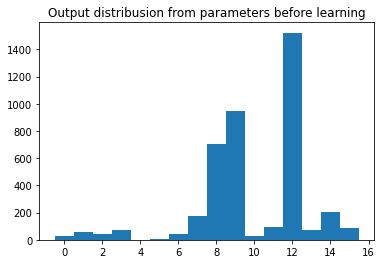

In [50]:
plt.bar([i for i in range(16)], before_learning, 1)
plt.title("Output distribusion from parameters before learning")

Text(0.5, 1.0, 'Output distribusion from parameters after learning')

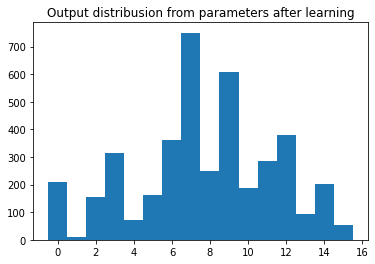

In [51]:
plt.bar([i for i in range(16)], after_learning, 1)
plt.title("Output distribusion from parameters after learning")

We can see that the distribution is closer to Gaussian after learning.  
Although we won't pursue it this time, it is still far from a clean Gaussian distribution, so there is room for improvement in the number of parameters, training steps, and hyperparameters of the quantum circuit.

Now we can learn the probability distribution by QCBM.